#  Predict which water pumps are faulty

**The goal is to identify with above 60% accuracy which water wells are faulty or non functional.** I will be using data from Taarifa and the Tanzanian Ministry of Water. The submission of my predictions will be in the format of .CSV with columns for 'id' as well as 'status_group'. Lets start by loading the data and getting a feel for it. 

In [1]:
import pandas as pd
import zipfile
zf_labl = zipfile.ZipFile('C:/Users/dakot/Downloads/train_labels.csv.zip')
zf_content = zipfile.ZipFile('C:/Users/dakot/Downloads/train_features.csv.zip')
df_label = pd.read_csv(zf_labl.open(zipfile.ZipFile.namelist(zf_labl)[0])) 
df_feats = pd.read_csv(zf_content.open(zipfile.ZipFile.namelist(zf_content)[0]))

In [2]:
df_label.describe(include='object')

,status_group
count,59400
unique,3
top,functional
freq,32259


**The df_label data frame contains the id along with status of the well. The status will be our dependant variable for this project, I believe I will utilize the ID label with the other features to ensure tracability throughout.**

In [3]:
#let us see the whole column profile of the data frame 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_feats.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
df_feats.shape, df_label.shape

((59400, 40), (59400, 2))

**The df_feats Data Frame contains all the features we will use to predict the status of any given well.** For the first iteration I will run a simple baseline. We see the shape of the features df is 59400 by 40 and the shape of the label df is 59400 by 2. Lets check the distribution of the status of the wells. 

In [5]:
df_label.status_group.value_counts(normalize = True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**Overall it appears the majority of wells are functional(54.3%), non functional is the second highest(38.42%). Functional needing repair rounds out the data set(7.26%).** If I were to make a blind prediction saying that all the wells were functional I would be correct around 54 percent of the time. Not bad but not nearly conclusive or useful for the real world. Lets dig deeper. 

For simplicity I will combine the two data frames to process before splitting. 


In [6]:
full = pd.DataFrame.merge(df_label,df_feats)

In [7]:
full.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
full.isnull().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

**After merging the data frames together I find there are some Null values that may skew our results or otherwise break our functions during the process.** For now we will drop all instances that are missing values, but later we may impute some values to help our models predict better if neeeded.  

In [9]:
clean = full.dropna(axis = 1)

In [10]:
clean.isna().sum()

id                       0
status_group             0
amount_tsh               0
date_recorded            0
gps_height               0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
recorded_by              0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

**Now that we have no NaN values lets make some test and tarin sets with our data. We want to predict status so we will call that the 'y' variable. All other features will be called our 'X' matrix of features.** 

In [11]:
from sklearn.model_selection import train_test_split
X1 = clean.drop(columns = ['status_group',], axis = 1)
y = clean['status_group']
X_train, X_test, y_train, y_test = train_test_split(X1, y,test_size = .5, random_state=42)

In [12]:
X_train.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,recorded_by,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
142,64130,0.0,2012-10-23,0,32.785025,-5.418031,Kwa Ramadhani,0,Lake Tanganyika,Tabora,14,5,Sikonge,Igigwa,0,GeoData Consultants Ltd,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump
1056,5968,0.0,2011-06-04,1804,34.767711,-9.089774,Kwa Deo Ngimbusi,0,Rufiji,Iringa,11,4,Njombe,Mdandu,65,GeoData Consultants Ltd,2009,gravity,gravity,gravity,vwc,user-group,pay when scheme fails,on failure,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
54991,53989,0.0,2012-10-08,0,34.531640,-3.727918,Mwabalomolo,0,Internal,Shinyanga,17,6,Meatu,Mwanjoro,0,GeoData Consultants Ltd,0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
23651,3849,0.0,2013-01-07,0,32.800493,-5.018881,Kwa Mkonde,0,Lake Tanganyika,Tabora,14,6,Tabora Urban,Chemchem,0,GeoData Consultants Ltd,0,other,other,other,other,other,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
36341,67824,0.0,2013-02-13,486,34.773950,-11.231885,Kwa Mzee Kanyali,0,Lake Nyasa,Ruvuma,10,3,Mbinga,Mbamba bay,60,GeoData Consultants Ltd,2008,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe


In [13]:
X_train.isna().sum().sum()

0

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import category_encoders as ce
import numpy as np 
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df
      

In [15]:
X_train_DC = dummyEncode(X_train)
X_train_DC.head()
X_test_DC = dummyEncode(X_test)
X_test_DC.head()
X = dummyEncode(X1)

C:\Users\dakot\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [16]:
X_train_DC.isna().sum().sum()
X_train_DC.shape

(29700, 33)

In [17]:
model= LogisticRegression()
model.fit(X_train_DC, y_train)
y_pred = model.predict(X_test_DC)
accuracy_score(y_test, y_pred)


C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6278451178451179

In [18]:
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         StandardScaler(), LogisticRegression(solver ='lbfgs',n_jobs=-1, multi_class = 'auto',C=2))
pipeline.fit(X_train_DC, y_train)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=[], drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, use_cat_names=True, verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=2, cla...enalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False))])

In [19]:
y_pred = pipeline.predict(X_train)


C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [20]:
pred = pd.DataFrame(y_pred, X_train_DC['id'])

In [21]:
pred.columns = ['status_group']

In [22]:
pred.head()
pred.shape
pred.head()

,status_group
id,
64130,non functional
5968,functional
53989,functional
3849,non functional
67824,non functional


In [23]:
newsub = pd.DataFrame(pred)
newsub.shape
sub_2 = newsub.index
subm = pd.DataFrame( newsub['status_group'],sub_2)
subm.head()
subm.reset_index(inplace = True)

In [24]:
#subm.to_csv('C:/Users/dakot/Documents/GitHub/sumbission1.csv',columns = ['id','status_group'], index = False )

In [25]:
subm.shape

(29700, 2)

Now to make it work for the actual test set. 


In [26]:
zf_test  = zipfile.ZipFile('C:/Users/dakot/Downloads/test_features.csv.zip')
df_test = pd.read_csv(zf_test.open(zipfile.ZipFile.namelist(zf_test)[0])) 

In [27]:
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [28]:
df_test.isna().sum()
nona = df_test.dropna(axis = 1)

In [29]:
nona.shape

(14358, 33)

In [30]:
X = dummyEncode(nona)

C:\Users\dakot\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [31]:
X.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,wpt_name,num_private,basin,region,region_code,district_code,lga,ward,population,recorded_by,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,255,1996,35.290799,-4.059696,633,0,0,8,21,3,62,16,321,0,2012,9,6,3,3,2,0,2,6,2,3,3,5,3,1,6,5
1,51630,0.0,255,1569,36.656709,-3.309214,1727,0,5,0,2,2,0,642,300,0,2000,3,1,0,7,4,0,2,6,2,2,2,8,6,0,1,1
2,17168,0.0,252,1567,34.767863,-5.004344,9483,0,0,18,13,2,108,1659,500,0,2010,9,6,3,7,4,0,2,6,2,2,2,5,3,1,6,5
3,45559,0.0,242,267,38.058046,-9.418672,5467,0,7,7,80,43,48,1178,250,0,1987,9,6,3,7,4,6,6,6,2,0,0,7,5,0,6,5
4,49871,500.0,306,1260,35.006123,-10.950412,5573,0,7,16,10,3,60,1061,60,0,2000,3,1,0,9,4,3,1,6,2,1,1,8,6,0,1,1


In [32]:
pipeline.fit(X_test, y_test)
y_preds = pipeline.predict(X)



C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [33]:
y_preds.shape

(14358,)

In [34]:
preds = pd.DataFrame(y_preds, X['id'])
preds.columns = ['status_group']
preds.head()

,status_group
id,
50785,non functional
51630,functional
17168,non functional
45559,non functional
49871,functional


In [35]:
newsubs = pd.DataFrame(preds)
newsubs.shape
sub_2s = newsubs.index
subms = pd.DataFrame( newsubs['status_group'],sub_2s)
subms.head()
subms.reset_index(inplace = True)

In [36]:
subms.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [37]:
#subms.to_csv('C:/Users/dakot/Documents/GitHub/sumbission1.csv',columns = ['id','status_group'], index = False )


The above got me a baseline of .53754 on kaggle. we can do better than that. 

In [38]:
from sklearn import tree
from sklearn.metrics import classification_report
 
clf = tree.DecisionTreeClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
 
y_pred2 = clf.predict(X)
#print(classification_report(y_test, y_pred2))
#print('\nAccuracy: {0:.4f}'.format(accuracy_score(y_test, y_pred2)))

In [39]:
y_pred2.shape

(14358,)

Lets try to automate the formatting for submission. 

In [40]:
def format(predictions):
    pre = pd.DataFrame(predictions, X['id'])
    pre.columns = ['status_group']
    new = pd.DataFrame(pre)
    sub_2s = new.index
    subs = pd.DataFrame( new['status_group'],sub_2s)
    subs.reset_index(inplace = True)
    print(subs.head(),subs.shape)
    subs.to_csv('C:/Users/dakot/Documents/GitHub/sumbission1.csv',columns = ['id','status_group'], index = False )
    return 'YAY!'


In [41]:
#format(y_pred2)

# Decision Tree Classifier leads!
kaggle score for the tree without a pipline  = 0.71054
Now lets pipeline this baby!

In [42]:
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         StandardScaler(), LogisticRegression(solver ='lbfgs',n_jobs=-1, multi_class = 'auto',C=2))
pipeline.fit(X_train, y_train)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=[], drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, use_cat_names=True, verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=2, cla...enalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False))])

In [43]:
pred3 = pipeline.predict(X)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [44]:
pred3

array(['non functional', 'functional', 'non functional', ...,
       'non functional', 'functional', 'non functional'], dtype=object)

In [45]:
#format(pred3)

standard scaled one hot encoded log_reg =  0.63769 for tracability  

## Ok for real this time decission tree in a pipeline 


In [46]:
treepipe = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         StandardScaler(),tree.DecisionTreeClassifier(random_state=42) )
treepipe.fit(X_train, y_train)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=[], drop_invariant=False, handle_unknown='impute',
       impute_missing=True, return_df=True, use_cat_names=True, verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeclassifier', DecisionTreeClassifier(...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [47]:
tpred = treepipe.predict(X_test)
print(accuracy_score(y_test,tpred))
pred4 = treepipe.predict(X)

0.7174747474747475


C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [48]:
#format(pred4)

score = 0.71040

In [49]:
from sklearn.preprocessing import RobustScaler
treepipe2 = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         RobustScaler(),tree.DecisionTreeClassifier(random_state=42) )
treepipe2.fit(X_train, y_train)
pred = treepipe.predict(X_test)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [50]:
accuracy_score(y_test,pred)

0.7174747474747475

In [51]:
pred5 = treepipe2.predict(X)

In [52]:
pred5


array(['non functional', 'functional', 'functional needs repair', ...,
       'functional', 'functional', 'non functional'], dtype=object)

In [53]:
#format(pred5)

score = 0.71040

# Ok this far I've dropped all rows with NAN's, lets fix some of the columns and see if that helps

In [54]:
# the training data set 
full.isna().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

# MONKEY PATCHING TIME!!!!

In [55]:
full.funder.fillna(full.funder.describe().top,inplace = True)
full.installer.fillna(full.installer.describe().top,inplace = True)
full.subvillage.fillna(full.subvillage.describe().top, inplace = True)
full.public_meeting.fillna(full.public_meeting.describe().top,inplace = True)
full.scheme_management.fillna(full.scheme_management.describe().top, inplace = True)
full.scheme_name.fillna(full.scheme_name.describe().top, inplace = True)
full.permit.fillna(full.permit.describe().top,inplace = True)

In [56]:
full.isna().sum().sum()

0

In [57]:
full.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'], dtype='object')

monkey patch complete on training data. Lets see the effects 

In [58]:
Xi = full.drop(columns= ['status_group','date_recorded'], axis = 1)
yi = full['status_group']

In [59]:
Xi.shape, yi.shape

((59400, 39), (59400,))

In [60]:
# DJ split that S*&&%
X_train, X_test, y_train, y_test = train_test_split(Xi, yi,test_size = .5, random_state=42)
#now encode it
X_trains = dummyEncode(X_train)
X_tests = dummyEncode(X_test)

C:\Users\dakot\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [61]:
#how does it like the trees
cl = tree.DecisionTreeClassifier(random_state=42)
cl = clf.fit(X_trains, y_train)
 
y_predictor = clf.predict(X_tests)
print(classification_report(y_test, y_predictor))
print('\nAccuracy: {0:.4f}'.format(accuracy_score(y_test, y_predictor)))
#accuracy of .699 for the train data when split how about the test data

                         precision    recall  f1-score   support

             functional       0.76      0.73      0.75     16110
functional needs repair       0.30      0.34      0.32      2174
         non functional       0.70      0.72      0.71     11416

              micro avg       0.70      0.70      0.70     29700
              macro avg       0.59      0.60      0.59     29700
           weighted avg       0.71      0.70      0.70     29700


Accuracy: 0.6993


# Monkey Patch All The DATAS!!!!!!

In [62]:
test = df_test
print(test.shape)
test.funder.fillna(test.funder.describe().top,inplace = True)
test.installer.fillna(test.installer.describe().top,inplace = True)
test.subvillage.fillna(test.subvillage.describe().top, inplace = True)
test.public_meeting.fillna(test.public_meeting.describe().top,inplace = True)
test.scheme_management.fillna(test.scheme_management.describe().top, inplace = True)
test.scheme_name.fillna(test.scheme_name.describe().top, inplace = True)
test.permit.fillna(test.permit.describe().top,inplace = True)

(14358, 40)


In [63]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,Borehole,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,Government Of Tanzania,1567,DWE,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,True,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,True,GeoData Consultants Ltd,VWC,Borehole,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,True,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [64]:
Xt = test.drop(columns = ['date_recorded'], axis = 1)
XT = dummyEncode(Xt)
#TREE ME!!!
cl = tree.DecisionTreeClassifier(random_state=42)
cl = clf.fit(X_trains, y_train)
 
y_predictors = clf.predict(XT)
# print(classification_report(y_test, y_predictor))
# print('\nAccuracy: {0:.4f}'.format(accuracy_score(y_test, y_predictor)))

In [65]:
#format(y_predictors)

Your submission scored 0.68881

In [66]:
#lets hit the pipe testing with standard scale then robust, log_reg and tree
logpipe = make_pipeline(RobustScaler(),
                        tree.DecisionTreeClassifier(random_state=42) )
logpipe.fit(X_trains, y_train)
predlog = logpipe.predict(X_test)
accuracy_score(y_test,predlog)
# yeah .64 is no bueno with standard scaler logistic regression
#robust scale log_regression is.63 which doesnt tickle my fancy 
# Standard scale D tree gives .69 but im not impressed
#robust scale Dtree gives a slightly higher .699

0.6991919191919191

In [67]:
# What about different encoding?
import category_encoders as ce
encoder = ce.HashingEncoder()
hashingpipe = make_pipeline(ce.HashingEncoder(),RobustScaler(),
                        tree.DecisionTreeClassifier(random_state=42) )
hashingpipe.fit(X_train, y_train)
predlogs = hashingpipe.predict(X_test)
accuracy_score(y_test,predlogs)


0.6991919191919191

Allright so far im not breaking through this barrier. So far the best score came from dropping all the nan values and a decision tree. lets get back to that.  


In [68]:
zf_test  = zipfile.ZipFile('C:/Users/dakot/Downloads/test_features.csv.zip')
df_test1 = pd.read_csv(zf_test.open(zipfile.ZipFile.namelist(zf_test)[0])) 

In [69]:
from sklearn.preprocessing import MinMaxScaler
df_test1.isna().sum()
df_test1['gps_height'].replace(0.0, np.nan, inplace=True)
df_test1['population'].replace(0.0, np.nan, inplace=True)
df_test1['amount_tsh'].replace(0.0, np.nan, inplace=True)
df_test1.isnull().sum()

id                           0
amount_tsh               10011
date_recorded                0
funder                     783
gps_height                4978
installer                  788
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                  94
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                5205
public_meeting             785
recorded_by                  0
scheme_management          939
scheme_name               6839
permit                     663
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [70]:
df_test1['gps_height'].fillna(df_test1.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
df_test1['gps_height'].fillna(df_test1.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
df_test1['gps_height'].fillna(df_test1['gps_height'].mean(), inplace=True)
df_test1['population'].fillna(df_test1.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
df_test1['population'].fillna(df_test1.groupby(['region'])['population'].transform('median'), inplace=True)
df_test1['population'].fillna(df_test1['population'].median(), inplace=True)
df_test1['amount_tsh'].fillna(df_test1.groupby(['region', 'district_code'])['amount_tsh'].transform('median'), inplace=True)
df_test1['amount_tsh'].fillna(df_test1.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
df_test1['amount_tsh'].fillna(df_test1['amount_tsh'].median(), inplace=True)
df_test1.isnull().sum()
features=['amount_tsh', 'gps_height', 'population']
scaler = MinMaxScaler(feature_range=(0,20))
df_test1[features] = scaler.fit_transform(df_test1[features])
df_test1[features].head(20)
df_test1.isna().sum()
df_test1['longitude'].replace(0.0, np.nan, inplace=True)
df_test1['latitude'].replace(0.0, np.nan, inplace=True)
df_test1['construction_year'].replace(0.0, np.nan, inplace=True)
df_test1['latitude'].fillna(df_test1.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
df_test1['longitude'].fillna(df_test1.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
df_test1['longitude'].fillna(df_test1.groupby(['region'])['longitude'].transform('mean'), inplace=True)
df_test1['construction_year'].fillna(df_test1.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
df_test1['construction_year'].fillna(df_test1.groupby(['region'])['construction_year'].transform('median'), inplace=True)
df_test1['construction_year'].fillna(df_test1.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
df_test1['construction_year'].fillna(df_test1['construction_year'].median(), inplace=True)
df_test1['date_recorded'] = pd.to_datetime(df_test1['date_recorded'])
df_test1['years_service'] = df_test1.date_recorded.dt.year - df_test1.construction_year
print(df_test1.isnull().sum())


id                          0
amount_tsh                  0
date_recorded               0
funder                    783
gps_height                  0
installer                 788
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 94
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            785
recorded_by                 0
scheme_management         939
scheme_name              6839
permit                    663
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

In [71]:
df_test1['gps_height'].fillna(df_test1.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
# df_test1['gps_height'].fillna(df_test1.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
# df_test1['gps_height'].fillna(df_test1['gps_height'].mean(), inplace=True)

In [72]:
print('first transform','\n',
      df_test1['gps_height'].describe())
print('\n','NULLS:',df_test1['gps_height'].isna().sum())

first transform 
 count    14358.000000
mean         7.759463
std          3.597792
min          0.000000
25%          5.958010
50%          7.759463
75%          9.923570
max         20.000000
Name: gps_height, dtype: float64

 NULLS: 0


In [73]:
df_test1['gps_height'].fillna(df_test1.groupby(['region'])['gps_height'].transform('mean'), inplace=True)

In [74]:
print('second transform','\n',
      df_test1['gps_height'].describe())
print('\n','NULLS:',df_test1['gps_height'].isna().sum())

second transform 
 count    14358.000000
mean         7.759463
std          3.597792
min          0.000000
25%          5.958010
50%          7.759463
75%          9.923570
max         20.000000
Name: gps_height, dtype: float64

 NULLS: 0


In [75]:
df_test1['gps_height'].fillna(df_test1['gps_height'].mean(), inplace=True)

In [76]:
print('last transform','\n',
      df_test1['gps_height'].describe())
print('\n','NULLS:',df_test1['gps_height'].isna().sum())

last transform 
 count    14358.000000
mean         7.759463
std          3.597792
min          0.000000
25%          5.958010
50%          7.759463
75%          9.923570
max         20.000000
Name: gps_height, dtype: float64

 NULLS: 0


# Alright thats a lot of code for a little cleaning. lets dump some trash 

In [77]:
garbage=['wpt_name','num_private','subvillage','region_code','recorded_by','management_group',
         'extraction_type_group','extraction_type_class','scheme_name','payment',
        'quality_group','quantity_group','source_type','source_class','waterpoint_type_group',
        'ward','public_meeting','permit','date_recorded','construction_year']
df_test1.drop(garbage,axis=1, inplace=True)

In [78]:
#take out any random capital letters in the entries
df_test1.waterpoint_type = df_test1.waterpoint_type.str.lower()
df_test1.funder = df_test1.funder.str.lower()
df_test1.basin = df_test1.basin.str.lower()
df_test1.region = df_test1.region.str.lower()
df_test1.source = df_test1.source.str.lower()
df_test1.lga = df_test1.lga.str.lower()
df_test1.management = df_test1.management.str.lower()
df_test1.quantity = df_test1.quantity.str.lower()
df_test1.water_quality = df_test1.water_quality.str.lower()
df_test1.payment_type=df_test1.payment_type.str.lower()
df_test1.extraction_type=df_test1.extraction_type.str.lower()

In [79]:
df_test1.columns


Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'basin', 'region', 'district_code', 'lga', 'population', 'scheme_management', 'extraction_type', 'management', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'years_service'], dtype='object')

# A few more lose ends to tie up...

In [80]:
df_test1["funder"].fillna("other", inplace=True)
df_test1["scheme_management"].fillna("other", inplace=True)
df_test1["installer"].fillna("other", inplace=True)
df_test1.isna().sum()

id                   0
amount_tsh           0
funder               0
gps_height           0
installer            0
longitude            0
latitude             0
basin                0
region               0
district_code        0
lga                  0
population           0
scheme_management    0
extraction_type      0
management           0
payment_type         0
water_quality        0
quantity             0
source               0
waterpoint_type      0
years_service        0
dtype: int64

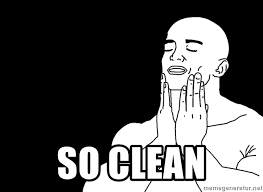

In [81]:
df_test1.head()
df_test1.shape

(14358, 21)

# Now that process again on the training data....YAY!
lets try to automate that mess 

In [82]:
#AUTOMATE ALL THE THINGS!!!
def MrClean(df):
    df_t= df
    df_t['gps_height'].replace(0.0, np.nan, inplace=True)
    df_t['population'].replace(0.0, np.nan, inplace=True)
    df_t['amount_tsh'].replace(0.0, np.nan, inplace=True)
    df_t['gps_height'].fillna(df_t.groupby(['region', 'district_code'])['gps_height'].transform('mean'), inplace=True)
    df_t['gps_height'].fillna(df_t.groupby(['region'])['gps_height'].transform('mean'), inplace=True)
    df_t['gps_height'].fillna(df_t['gps_height'].mean(), inplace=True)
    df_t['population'].fillna(df_t.groupby(['region', 'district_code'])['population'].transform('median'), inplace=True)
    df_t['population'].fillna(df_t.groupby(['region'])['population'].transform('median'), inplace=True)
    df_t['population'].fillna(df_t['population'].median(), inplace=True)
    df_t['amount_tsh'].fillna(df_t.groupby(['region', 'district_code'])['amount_tsh'].transform('median'), inplace=True)
    df_t['amount_tsh'].fillna(df_t.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
    df_t['amount_tsh'].fillna(df_t['amount_tsh'].median(), inplace=True)
    features=['amount_tsh', 'gps_height', 'population']
    scaler = MinMaxScaler(feature_range=(0,20))
    df_t[features] = scaler.fit_transform(df_t[features])
    df_t['longitude'].replace(0.0, np.nan, inplace=True)
    df_t['latitude'].replace(0.0, np.nan, inplace=True)
    df_t['construction_year'].replace(0.0, np.nan, inplace=True)
    df_t['latitude'].fillna(df_t.groupby(['region', 'district_code'])['latitude'].transform('mean'), inplace=True)
    df_t['longitude'].fillna(df_t.groupby(['region', 'district_code'])['longitude'].transform('mean'), inplace=True)
    df_t['longitude'].fillna(df_t.groupby(['region'])['longitude'].transform('mean'), inplace=True)
    df_t['construction_year'].fillna(df_t.groupby(['region', 'district_code'])['construction_year'].transform('median'), inplace=True)
    df_t['construction_year'].fillna(df_t.groupby(['region'])['construction_year'].transform('median'), inplace=True)
    df_t['construction_year'].fillna(df_t.groupby(['district_code'])['construction_year'].transform('median'), inplace=True)
    df_t['construction_year'].fillna(df_t['construction_year'].median(), inplace=True)
    df_t['date_recorded'] = pd.to_datetime(df_t['date_recorded'])
    df_t['years_service'] = df_t.date_recorded.dt.year - df_t.construction_year
   
    garbage=['wpt_name','num_private','subvillage','region_code','recorded_by','management_group',
         'extraction_type_group','extraction_type_class','scheme_name','payment',
        'quality_group','quantity_group','source_type','source_class','waterpoint_type_group',
        'ward','public_meeting','permit','date_recorded','construction_year']
    df_t.drop(garbage,axis=1, inplace=True)
    df_t.waterpoint_type = df_t.waterpoint_type.str.lower()
    df_t.funder = df_t.funder.str.lower()
    df_t.basin = df_t.basin.str.lower()
    df_t.region = df_t.region.str.lower()
    df_t.source = df_t.source.str.lower()
    df_t.lga = df_t.lga.str.lower()
    df_t.management = df_t.management.str.lower()
    df_t.quantity = df_t.quantity.str.lower()
    df_t.water_quality = df_t.water_quality.str.lower()
    df_t.payment_type=df_t.payment_type.str.lower()
    df_t.extraction_type=df_t.extraction_type.str.lower()
    df_t["funder"].fillna("other", inplace=True)
    df_t["scheme_management"].fillna("other", inplace=True)
    df_t["installer"].fillna("other", inplace=True)
    return df_t

In [83]:
#Full is the df of both the train_features csv and train_labels merged 
full = pd.DataFrame.merge(df_label,df_feats)
full.shape
print(full.columns)

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'], dtype='object')


In [84]:
#Call out mrclean!
soclean =  MrClean(full)

In [85]:
soclean.head()
#soclean.shape

,id,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,years_service
0,69572,functional,0.342846,roman,10.349650,Roman,34.938093,-9.856322,lake nyasa,iringa,5,ludewa,0.070822,VWC,gravity,vwc,annually,soft,enough,spring,communal standpipe,12.0
1,8776,functional,0.011417,grumeti,10.412587,GRUMETI,34.698766,-2.147466,lake victoria,mara,2,serengeti,0.182957,Other,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,3.0
2,34310,functional,0.001417,lottery club,5.426573,World vision,37.460664,-3.821329,pangani,manyara,4,simanjiro,0.163284,VWC,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,4.0
3,67743,non functional,0.002846,unicef,2.468531,UNICEF,38.486161,-11.155298,ruvuma / southern coast,mtwara,63,nanyumbu,0.037378,VWC,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,27.0
4,19728,functional,0.014274,action in a,8.024794,Artisan,31.130847,-1.825359,lake victoria,kagera,1,karagwe,0.130496,other,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,8.0


# TIME FOR TREES

In [86]:
yc = soclean['status_group']
Xc = soclean

In [87]:
Xc.head()

,id,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,years_service
0,69572,functional,0.342846,roman,10.349650,Roman,34.938093,-9.856322,lake nyasa,iringa,5,ludewa,0.070822,VWC,gravity,vwc,annually,soft,enough,spring,communal standpipe,12.0
1,8776,functional,0.011417,grumeti,10.412587,GRUMETI,34.698766,-2.147466,lake victoria,mara,2,serengeti,0.182957,Other,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,3.0
2,34310,functional,0.001417,lottery club,5.426573,World vision,37.460664,-3.821329,pangani,manyara,4,simanjiro,0.163284,VWC,gravity,vwc,per bucket,soft,enough,dam,communal standpipe multiple,4.0
3,67743,non functional,0.002846,unicef,2.468531,UNICEF,38.486161,-11.155298,ruvuma / southern coast,mtwara,63,nanyumbu,0.037378,VWC,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,27.0
4,19728,functional,0.014274,action in a,8.024794,Artisan,31.130847,-1.825359,lake victoria,kagera,1,karagwe,0.130496,other,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,8.0


In [88]:
Xc.drop(columns = ['status_group'], axis = 1, inplace = True)

In [89]:
Xc.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'basin', 'region', 'district_code', 'lga', 'population', 'scheme_management', 'extraction_type', 'management', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type', 'years_service'], dtype='object')

In [90]:
#split this ish 
X_train, X_test, y_train, y_test = train_test_split(Xc, yc,test_size = .2, random_state=42)

In [91]:
X_train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,years_service
3607,454,0.002846,dmdd,15.258741,DMDD,35.426020,-4.227446,internal,manyara,1,babati,0.104266,Water Board,gravity,water board,per bucket,soft,insufficient,spring,communal standpipe,15.0
50870,510,0.014274,cmsr,8.024794,Gove,35.510074,-5.724555,internal,dodoma,6,bahi,0.130496,VWC,india mark ii,vwc,never pay,soft,enough,shallow well,hand pump,11.0
20413,14146,0.014274,kkkt,8.024794,KKKT,32.499866,-9.081222,lake rukwa,mbeya,6,mbozi,0.130496,VWC,other,vwc,never pay,soft,enough,shallow well,other,11.0
52806,47410,0.014274,other,8.024794,other,34.060484,-8.830208,rufiji,mbeya,7,mbarali,0.130496,VWC,gravity,vwc,monthly,soft,insufficient,river,communal standpipe,8.0
50091,1288,0.017131,ki,7.783217,Ki,37.032690,-6.040787,wami / ruvu,morogoro,1,kilosa,0.078035,VWC,other,vwc,on failure,salty,enough,shallow well,other,14.0


In [92]:
# TREES!!!
cleanpipe = make_pipeline(ce.OneHotEncoder(use_cat_names=True),StandardScaler(),
                        tree.DecisionTreeClassifier(random_state=42) )
cleanpipe.fit(X_train, y_train)
preds = cleanpipe.predict(X_test)
accuracy_score(y_test,preds)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.7477272727272727

In [93]:
preddi = cleanpipe.predict(df_test1)

C:\Users\dakot\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [94]:
preddi.shape

(14358,)

In [95]:
#format(preddi)

0.71973 now for some other models

In [96]:
full = pd.DataFrame.merge(df_label,df_feats)
full.shape
print(full.columns)
soclean =  MrClean(full)
train = soclean
test = df_test1

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'], dtype='object')


In [97]:
train.shape,test.shape

((59400, 22), (14358, 21))

In [98]:
target = train.pop('status_group')
train['train']=1
test['train']=0

In [99]:
combo = pd.concat([train, test])
combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73758 entries, 0 to 14357
Data columns (total 22 columns):
id                   73758 non-null int64
amount_tsh           73758 non-null float64
funder               73758 non-null object
gps_height           73758 non-null float64
installer            73758 non-null object
longitude            73758 non-null float64
latitude             73758 non-null float64
basin                73758 non-null object
region               73758 non-null object
district_code        73758 non-null int64
lga                  73758 non-null object
population           73758 non-null float64
scheme_management    73758 non-null object
extraction_type      73758 non-null object
management           73758 non-null object
payment_type         73758 non-null object
water_quality        73758 non-null object
quantity             73758 non-null object
source               73758 non-null object
waterpoint_type      73758 non-null object
years_service        73758 n

In [100]:
combo['funder'] = pd.factorize(combo['funder'])[0]
combo['installer'] = pd.factorize(combo['installer'])[0]
combo['scheme_management'] = pd.factorize(combo['scheme_management'])[0]
combo['extraction_type'] = pd.factorize(combo['extraction_type'])[0]
combo['management'] = pd.factorize(combo['management'])[0]
combo['payment_type'] = pd.factorize(combo['payment_type'])[0]
combo['water_quality'] = pd.factorize(combo['water_quality'])[0]
combo['quantity'] = pd.factorize(combo['quantity'])[0]
combo['source'] = pd.factorize(combo['source'])[0]
combo['waterpoint_type'] = pd.factorize(combo['waterpoint_type'])[0]
combo['basin'] = pd.factorize(combo['basin'])[0]
combo['region'] = pd.factorize(combo['region'])[0]
combo['lga'] = pd.factorize(combo['lga'])[0]
combo['district_code'] = pd.factorize(combo['district_code'])[0]
combo['years_service'] = pd.factorize(combo['years_service'])[0]
combo.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,population,scheme_management,extraction_type,management,payment_type,water_quality,quantity,source,waterpoint_type,years_service,train
0,69572,0.342846,0,10.349650,0,34.938093,-9.856322,0,0,0,0,0.070822,0,0,0,0,0,0,0,0,0,1
1,8776,0.011417,1,10.412587,1,34.698766,-2.147466,1,1,1,1,0.182957,1,0,1,1,0,1,1,0,1,1
2,34310,0.001417,2,5.426573,2,37.460664,-3.821329,2,2,2,2,0.163284,0,0,0,2,0,0,2,1,2,1
3,67743,0.002846,3,2.468531,3,38.486161,-11.155298,3,3,3,3,0.037378,0,1,0,1,0,2,3,1,3,1
4,19728,0.014274,4,8.024794,4,31.130847,-1.825359,1,4,4,4,0.130496,2,0,2,1,0,3,1,0,4,1


In [101]:
train_df = combo[combo["train"] == 1]
test_df = combo[combo["train"] == 0]
train_df.drop(["train"], axis=1, inplace=True)
train_df.drop(['id'],axis=1, inplace=True)
test_df.drop(["train"], axis=1, inplace=True)

C:\Users\dakot\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
X = train_df
y = target

In [103]:
X.shape,y.shape

((59400, 20), (59400,))

In [104]:
y.head()

0        functional
1        functional
2        functional
3    non functional
4        functional
Name: status_group, dtype: object

In [105]:
from sklearn.ensemble import RandomForestClassifier
model_rfc = RandomForestClassifier(n_estimators=1000, n_jobs = -1)

In [146]:
score = cross_val_score(model_rfc, X, y, cv=3, n_jobs = -1)

In [147]:
score.mean()

0.8032323232323232

In [107]:
X_test=test_df
X_test.shape

(14358, 21)

In [108]:
model_rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [109]:
X.info()
importances = model_rfc.feature_importances_
importances

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 20 columns):
amount_tsh           59400 non-null float64
funder               59400 non-null int64
gps_height           59400 non-null float64
installer            59400 non-null int64
longitude            59400 non-null float64
latitude             59400 non-null float64
basin                59400 non-null int64
region               59400 non-null int64
district_code        59400 non-null int64
lga                  59400 non-null int64
population           59400 non-null float64
scheme_management    59400 non-null int64
extraction_type      59400 non-null int64
management           59400 non-null int64
payment_type         59400 non-null int64
water_quality        59400 non-null int64
quantity             59400 non-null int64
source               59400 non-null int64
waterpoint_type      59400 non-null int64
years_service        59400 non-null int64
dtypes: float64(5), int64(15)
memory usag

array([0.02569334, 0.04666803, 0.07529815, 0.03728068, 0.14703889,
       0.1446371 , 0.01632884, 0.02263676, 0.02098045, 0.03005277,
       0.05089257, 0.01605974, 0.05536476, 0.01781109, 0.03208769,
       0.01410706, 0.11371033, 0.02961312, 0.05723822, 0.04650041])

In [110]:
X_test.shape, X.shape

((14358, 21), (59400, 20))

In [111]:
a=X_test['id']
X_test.drop(['id'],axis=1, inplace=True)
y_pred = model_rfc.predict(X_test)

C:\Users\dakot\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [112]:
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [113]:
a.head()

0    50785
1    51630
2    17168
3    45559
4    49871
Name: id, dtype: int64

In [114]:
y_pred.shape,a.shape

((14358,), (14358,))

In [115]:
y_pred=pd.DataFrame(y_pred)
y_pred['id']=a
y_pred.columns=['status_group','id']
y_pred=y_pred[['id','status_group']]

In [116]:
y_pred.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [117]:
#y_pred.to_csv('C:/Users/dakot/Documents/GitHub/sumbission.csv', index = False )

# Random forest gets the lead. 0.81487

In [118]:
#!pip install xgboost

In [119]:
from xgboost import XGBClassifier
modelxgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 4, maximize = False, eval_metric = 'merror', eta = .2,
                      max_depth = 14, colsample_bytree = .4)

In [120]:
#print(cross_val_score(modelxgb, X, y, cv=3,n_jobs = -1))
modelxgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, eta=0.2, eval_metric='merror', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=14, maximize=False,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nrounds='min.error.idx', nthread=None, num_class=4,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [121]:
y_preds = modelxgb.predict(X_test)

In [122]:
y_preds=pd.DataFrame(y_preds)
y_preds['id']=a
y_preds.columns=['status_group','id']
y_preds=y_preds[['id','status_group']]

In [123]:
y_preds.shape

(14358, 2)

In [124]:
y_preds.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [125]:
y_preds.to_csv('C:/Users/dakot/Documents/GitHub/sumbissionxgb.csv', index = False )

# XGboost falls short with 81292

In [126]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=1000)

In [127]:
#print(cross_val_score(knn, X, y, cv=3,n_jobs = -1))

# With that low of cross vals i wont even submit the KNN 

In [128]:
cl = tree.DecisionTreeClassifier(random_state=42)


In [129]:
#print(cross_val_score(cl, X, y, cv=3,n_jobs = -1))

NameError: name 'cross_val_score' is not defined

In [ ]:
#cl.fit(X,y)

In [ ]:
#y_predcl = cl.predict(X_test)

In [ ]:
y_predcl=pd.DataFrame(y_predcl)
y_predcl['id']=a
y_predcl.columns=['status_group','id']
y_predcl=y_predcl[['id','status_group']]

In [ ]:
y_predcl.head()

In [ ]:
y_predcl.shape

In [ ]:
#y_predcl.to_csv('C:/Users/dakot/Documents/GitHub/sumbissiondtc.csv', index = False )

# Decision tree classifier gets 0.70566

In [ ]:
log = LogisticRegression(solver ='saga',n_jobs=-1, multi_class = 'auto',C=1.0)

In [ ]:
print(cross_val_score(log, X, y, cv=3,n_jobs = -1))
log.fit(X,y)

In [ ]:
y_predlog =log.predict(X_test)

In [ ]:
y_predlog=pd.DataFrame(y_predlog)
y_predlog['id']=a
y_predlog.columns=['status_group','id']
y_predlog=y_predlog[['id','status_group']]

In [ ]:
y_predlog.head()

In [ ]:
#y_predlog.to_csv('C:/Users/dakot/Documents/GitHub/sumbissionlog.csv', index = False)

# logistic regression = 0.61359

In [130]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score

In [141]:
clf = ExtraTreesClassifier(n_estimators=500, max_depth=None,
                           min_samples_split=10, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)

In [142]:
scores.mean()

0.8092593497532563

In [ ]:
clf = RandomForestClassifier(n_estimators=5000, max_depth=None,
                             min_samples_split=10, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()                               

In [149]:
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [150]:
pred_rfc =clf.predict(X_test)

In [151]:
pred_rfc=pd.DataFrame(pred_rfc)
pred_rfc ['id']=a
pred_rfc .columns=['status_group','id']
pred_rfc = pred_rfc[['id','status_group']]

In [152]:
pred_rfc.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [153]:
pred_rfc.to_csv('C:/Users/dakot/Documents/GitHub/sumbissionrfc.csv', index = False)

# Lets play with something new and exciting
TOTry: 
ensembles (either with bagging, boosting or stacking)
mean-encoding of target-variable
plot importance if using tree-based models, and drop non important features.
create new features from the ones you have. (feature-engineering)
try to remove features that are very similar to each other.
play around with both dummies and label-encoding.
if you use just dummies-variables and get A LOT of features, perform PCA or LDA on it to minimize the feature-space
